### Vader Sentiment Analysis
- Applied to entire January6th Committee Hearing conversation
- Applied to the individual topics determined by LSA/CountVect topic modeling

In [1]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.util import ngrams
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import re

import seaborn as sns
import matplotlib.pyplot as plt

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jennihawk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
#got tweets at 1:15 Pacific Time 10/14/22
tweets = pd.read_csv('/Users/jennihawk/Documents/Data Science Projects/Project_NLP/TweetBatch3.csv')
tweets.head()

,text,cleaned
0,@ReallyAmerican1 #Roevember and\n#ForThePeople and\n#VoteBlueIn2022 and \n#StandWithUkraine️ and\n#PeopleOverPolitics and\n#OathBreakerMAGA and\n#LGBTQHistoryMonth and\n#InflationReductionAct and\n#RepublicanWarOnSeniors and\n#SocialSecurityIsOurMoney and\n#January6thCommitteeHearings...,roevember and forthepeople and votebluein2022 and standwithukraine and peopleoverpolitics and oathbreakermaga and lgbtqhistorymonth and inflationreductionact and republicanwaronseniors and socialsecurityisourmoney and january6thcommitteehearings
1,RT @sandibachom: IS THIS THING ON???!!This is pathetic. ACTING Sec of Defense Chris Miller was the ONLY person who can deploy the national…,rt is this thing on this is pathetic acting sec of defense chris miller was the only person who can deploy the national
2,RT @sandibachom: IS THIS THING ON???!!This is pathetic. ACTING Sec of Defense Chris Miller was the ONLY person who can deploy the national…,rt is this thing on this is pathetic acting sec of defense chris miller was the only person who can deploy the national
3,RT @tleehumphrey: Today is the beginning of the inquiry into the Trudeau gov’s use of the Emergencies Act against the #FreedomConvoy so wha…,rt today is the beginning of the inquiry into the trudeau gov use of the emergencies act against the freedomconvoy so wha
4,RT @AdamKinzinger: Mitch McConnell.\nKevin McCarthy.\nThey both knew Trump was responsible. \nThey both called him out.\nThey both backed down.…,rt mitch mcconnell kevin mccarthy they both knew trump was responsible they both called him out they both backed down


## Sentiment On Entire Conversation
- Video that inspired code https://www.youtube.com/watch?v=YdRTs0LmiuU

#### Create Sentiment Labels
- from vader compound comp = score['compound'] we are computing sentiments with conditional logic
- then concatonate numbers to dataframe

In [4]:
for index, row in tweets['cleaned'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if comp <= -0.05:
        tweets.loc[index, 'sentiment'] = "negative"
    elif comp >= 0.05:
        tweets.loc[index, 'sentiment'] = "positive"
    else:
        tweets.loc[index, 'sentiment'] = "neutral"
    tweets.loc[index, 'neg'] = neg
    tweets.loc[index, 'neu'] = neu
    tweets.loc[index, 'pos'] = pos
    tweets.loc[index, 'compound'] = comp

tweets.head(5)

,text,cleaned,sentiment,neg,neu,pos,compound
0,@ReallyAmerican1 #Roevember and\n#ForThePeople and\n#VoteBlueIn2022 and \n#StandWithUkraine️ and\n#PeopleOverPolitics and\n#OathBreakerMAGA and\n#LGBTQHistoryMonth and\n#InflationReductionAct and\n#RepublicanWarOnSeniors and\n#SocialSecurityIsOurMoney and\n#January6thCommitteeHearings...,roevember and forthepeople and votebluein2022 and standwithukraine and peopleoverpolitics and oathbreakermaga and lgbtqhistorymonth and inflationreductionact and republicanwaronseniors and socialsecurityisourmoney and january6thcommitteehearings,neutral,0.000,1.000,0.000,0.0000
1,RT @sandibachom: IS THIS THING ON???!!This is pathetic. ACTING Sec of Defense Chris Miller was the ONLY person who can deploy the national…,rt is this thing on this is pathetic acting sec of defense chris miller was the only person who can deploy the national,negative,0.141,0.802,0.057,-0.4939
2,RT @sandibachom: IS THIS THING ON???!!This is pathetic. ACTING Sec of Defense Chris Miller was the ONLY person who can deploy the national…,rt is this thing on this is pathetic acting sec of defense chris miller was the only person who can deploy the national,negative,0.141,0.802,0.057,-0.4939
3,RT @tleehumphrey: Today is the beginning of the inquiry into the Trudeau gov’s use of the Emergencies Act against the #FreedomConvoy so wha…,rt today is the beginning of the inquiry into the trudeau gov use of the emergencies act against the freedomconvoy so wha,neutral,0.000,1.000,0.000,0.0000
4,RT @AdamKinzinger: Mitch McConnell.\nKevin McCarthy.\nThey both knew Trump was responsible. \nThey both called him out.\nThey both backed down.…,rt mitch mcconnell kevin mccarthy they both knew trump was responsible they both called him out they both backed down,positive,0.000,0.841,0.159,0.3400


#### Sentiment Visualization
- Dataframe for each sentiment (pos, neg, neu)

In [5]:
tweets_df_negative = tweets[tweets["sentiment"]=="negative"]
tweets_df_positive = tweets[tweets["sentiment"]=="positive"]
tweets_df_neutral = tweets[tweets["sentiment"]=="neutral"]

#### Donut Chart

In [6]:
#function for count_values in single columns
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False, normalize=True)*100,2)
    return pd.concat([total,percentage], axis=1, keys = ['Total', 'Percentage'])

In [7]:
#call count values function to count values for sentiment
count_values_in_column(tweets, "sentiment")


,Total,Percentage
positive,14884,42.53
negative,12551,35.87
neutral,7558,21.60


In [8]:
#create data for pie chart
piechart = count_values_in_column(tweets, "sentiment")
names = piechart.index
size=piechart["Percentage"]

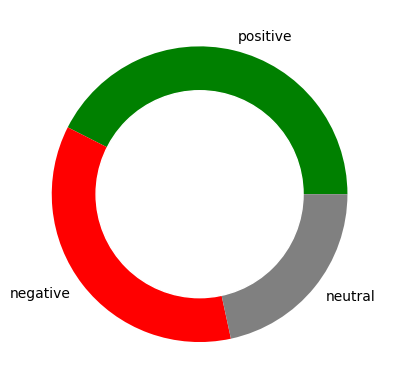

In [9]:
#create a circle for the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color = 'white')
plt.pie(size, labels=names, colors=['green', 'red', 'grey'])
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

#### Review Tweets for each Sentiment
- Do these make sense? 
- Negative Review if compound <= -0.05
- Positive Review if compound >= 0.05

In [10]:
#review n rows with largest negative scores
tweets.nlargest(40,'neg')

,text,cleaned,sentiment,neg,neu,pos,compound
31955,Ugh. This shit again. #January6thCommitteeHearings,ugh this shit again january6thcommitteehearings,negative,0.681,0.319,0.000,-0.7506
15952,ANGRY ANGRY ANGRY. It's way beyond bourbon.\n@January6thCmte #January6thCommitteeHearings,angry angry angry it way beyond bourbon january6thcommitteehearings,negative,0.664,0.336,0.000,-0.8720
27306,no one gives a shit #January6thCommitteeHearings,no one gives shit january6thcommitteehearings,negative,0.659,0.341,0.000,-0.7003
7111,@RepFischbach @SteveScalise All lies. Once a liar ALWAYS a liar Steve. #January6thCommitteeHearings,all lies once liar always liar steve january6thcommitteehearings,negative,0.653,0.347,0.000,-0.8555
23326,"@alexbruesewitz This dumb fuck put ""violence"" in quotes. Fuck him. #January6thCommitteeHearings #magaloid #TreasonHasConsequences",this dumb fuck put violence in quotes fuck him january6thcommitteehearings magaloid treasonhasconsequences,negative,0.643,0.357,0.000,-0.9371
27212,#SteveScalise \n\nLiar Liar Pants On Fire\n#insurrection #January6thCommitteeHearings https://t.co/Dd6tPYBCXX,stevescalise liar liar pants on fire insurrection january6thcommitteehearings,negative,0.643,0.357,0.000,-0.8402
25471,Drone strike victim families feel sorry that our warmongers were frightened #January6thCommitteeHearings https://t.co/3NT3Vb2hpo,drone strike victim families feel sorry that our warmongers were frightened january6thcommitteehearings,negative,0.624,0.376,0.000,-0.8625
9236,Hell fu*king yeah!\n#January6thCommitteeHearings\n#FridayThoughts \n#FridayMorning\n https://t.co/PlSKuExf2a,hell fu king yeah january6thcommitteehearings fridaythoughts fridaymorning,negative,0.600,0.258,0.142,-0.8442
27162,RT @AndThatAndThis: #SteveScalise \n\nLiar Liar Pants On Fire\n#insurrection #January6thCommitteeHearings,rt stevescalise liar liar pants on fire insurrection january6thcommitteehearings,negative,0.600,0.400,0.000,-0.8402
14501,These stupid demos are crazy@l #January6thCommitteeHearings,these stupid demos are crazy january6thcommitteehearings,negative,0.592,0.408,0.000,-0.7003


In [11]:
# review n rows with largest positive scores
tweets.nlargest(50,'pos')

,text,cleaned,sentiment,neg,neu,pos,compound
32371,#January6thCommitteeHearings \n#january6thHearing @DrKSampsell @1CaroleBell \n\nStunning. Stunning. Stunning. Stunning.,january6thcommitteehearings january6thhearing stunning stunning stunning stunning,positive,0.000,0.161,0.839,0.8555
20072,@mehdirhasan Truly.\n#January6thCommitteeHearings\nhttps://t.co/sXkvXKDUXU,truly january6thcommitteehearings,positive,0.000,0.256,0.744,0.4404
467,Interesting @SpeakerPelosi @SenSchumer @POTUS @VP #January6thCommitteeHearings https://t.co/kLuSHFbdwK,interesting january6thcommitteehearings,positive,0.000,0.270,0.730,0.4019
33981,*https://t.co/1PEgHzVXBg🏛️🪑💗💼\n#January6thCommitteeHearings:\n|⚖️&amp;✌️ Justice &amp; Peace |:,january6thcommitteehearings amp justice amp peace,positive,0.000,0.303,0.697,0.7845
24027,Yeah #January6thCommitteeHearings https://t.co/tKKqHE0edd,yeah january6thcommitteehearings,positive,0.000,0.312,0.688,0.2960
28669,Joke #January6thCommitteeHearings,joke january6thcommitteehearings,positive,0.000,0.312,0.688,0.2960
13267,Fantastic recap #January6thCommitteeHearings https://t.co/80qDp9WEwK,fantastic recap january6thcommitteehearings,positive,0.000,0.357,0.643,0.5574
27670,Pelosi kept so calm. Amazing. #January6thCommitteeHearings,pelosi kept so calm amazing january6thcommitteehearings,positive,0.000,0.361,0.639,0.7946
6047,"It truly breaks my heart to see @SpeakerPelosi @SenSchumer sticking together like two genuine, loving, caring grandparents 😢 @TheDemocrats in majority truly are a caring party of people. #January6thCommitteeHearings",it truly breaks my heart to see sticking together like two genuine loving caring grandparents in majority truly are caring party of people january6thcommitteehearings,positive,0.000,0.386,0.614,0.9764
9908,Wow... just wow... #January6thCommitteeHearings #TrumpIsGoingToJail #CapitolRiot #NancyPelosi https://t.co/8NgkAGwhsC,wow just wow january6thcommitteehearings trumpisgoingtojail capitolriot nancypelosi,positive,0.000,0.397,0.603,0.8225


### Vader Sentiment on Topics Identified via LSA Topic Modeling

In [12]:
stop_words = stopwords.words('english')
stop_words.extend(['rt', 'january', 'january6thcommitteehearings', 'ja', 'january6thcomm', '6th'])
tweets['cleaned'] = tweets['cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

#### Tokenize Words in Cleaned Column

In [13]:
tweets['tokenized'] = tweets.apply(lambda row: nltk.word_tokenize(row['cleaned']), axis=1)

In [14]:
tweets.head()

,text,cleaned,sentiment,neg,neu,pos,compound,tokenized
0,@ReallyAmerican1 #Roevember and\n#ForThePeople and\n#VoteBlueIn2022 and \n#StandWithUkraine️ and\n#PeopleOverPolitics and\n#OathBreakerMAGA and\n#LGBTQHistoryMonth and\n#InflationReductionAct and\n#RepublicanWarOnSeniors and\n#SocialSecurityIsOurMoney and\n#January6thCommitteeHearings...,roevember forthepeople votebluein2022 standwithukraine peopleoverpolitics oathbreakermaga lgbtqhistorymonth inflationreductionact republicanwaronseniors socialsecurityisourmoney,neutral,0.000,1.000,0.000,0.0000,"[roevember, forthepeople, votebluein2022, standwithukraine, peopleoverpolitics, oathbreakermaga, lgbtqhistorymonth, inflationreductionact, republicanwaronseniors, socialsecurityisourmoney]"
1,RT @sandibachom: IS THIS THING ON???!!This is pathetic. ACTING Sec of Defense Chris Miller was the ONLY person who can deploy the national…,thing pathetic acting sec defense chris miller person deploy national,negative,0.141,0.802,0.057,-0.4939,"[thing, pathetic, acting, sec, defense, chris, miller, person, deploy, national]"
2,RT @sandibachom: IS THIS THING ON???!!This is pathetic. ACTING Sec of Defense Chris Miller was the ONLY person who can deploy the national…,thing pathetic acting sec defense chris miller person deploy national,negative,0.141,0.802,0.057,-0.4939,"[thing, pathetic, acting, sec, defense, chris, miller, person, deploy, national]"
3,RT @tleehumphrey: Today is the beginning of the inquiry into the Trudeau gov’s use of the Emergencies Act against the #FreedomConvoy so wha…,today beginning inquiry trudeau gov use emergencies act freedomconvoy wha,neutral,0.000,1.000,0.000,0.0000,"[today, beginning, inquiry, trudeau, gov, use, emergencies, act, freedomconvoy, wha]"
4,RT @AdamKinzinger: Mitch McConnell.\nKevin McCarthy.\nThey both knew Trump was responsible. \nThey both called him out.\nThey both backed down.…,mitch mcconnell kevin mccarthy knew trump responsible called backed,positive,0.000,0.841,0.159,0.3400,"[mitch, mcconnell, kevin, mccarthy, knew, trump, responsible, called, backed]"


#### Countvectorizer + LSA 

In [15]:
corpus = list(tweets.cleaned)

In [16]:
#turn corpus into a document-term matrix
vectorizer = CountVectorizer()
doc_term = vectorizer.fit_transform(corpus)
doc_term_df = pd.DataFrame(doc_term.toarray(), columns=vectorizer.get_feature_names())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
doc_term_df.shape

(34993, 9398)

In [18]:
word_count = sum([len(d.split(' ')) for d in corpus]) > 100000
word_count

True

In [19]:
doc_term_df.iloc[:, : 100]

,00,000,01,05,08,09,10,100,1000,1000x,...,29,292,29m,2a,2d,2day,2ndwin,2pro,30,30k
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34988,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34991,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### LSA: Reduce Dimensionality 
- LSA is just SVD on the document term matrix

In [20]:
#TruncatedSVD breaks everything down into designated number of topics
lsa = TruncatedSVD(4)
lsa.fit(doc_term)
lsa

TruncatedSVD(n_components=4)

In [21]:
topic_term = lsa.components_.round(3)
topic_term

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0., -0., ..., -0., -0., -0.],
       [-0., -0.,  0., ..., -0., -0., -0.]])

#### Turn topic_term into dataframe

In [22]:
topic_term_df = pd.DataFrame(topic_term.round(3),
                index = ["component_1", "component_2", "component_3", "component_4"],
                columns = vectorizer.get_feature_names())
topic_term_df.head()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,01,05,08,09,10,100,1000,1000x,...,yup,zacksnyder,zelazny,zero,zim,zimbabwe,zone,zoom,zuma,zzy
component_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
component_3,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.001,0.0,-0.0,...,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0
component_4,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.001,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


#### Easier to read: Function displays the top terms in each topic 

In [23]:
def display_topics(model, feature_names, no_top_words, topic_names = None): 
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix + 1)
        else:
            print("\nTopic: ", topic_names[ix])
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    print("\n")
    return model, feature_names, no_top_words

In [24]:
#number is the number of top terms you want to see
output = display_topics(lsa, vectorizer.get_feature_names(), 8)
output


Topic  1
trump, knew, responsible, called, mcconnell, mccarthy, mitch, kevin

Topic  2
trump, violence, democracy, mark, attack, decided, summoned, excuse

Topic  3
mark, democracy, gop, country, maga, without, love, overthrowing

Topic  4
lost, stone, roger, video, help, coup, yet, new




/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(TruncatedSVD(n_components=4),
 ['00',
  '000',
  '01',
  '05',
  '08',
  '09',
  '10',
  '100',
  '1000',
  '1000x',
  '100s',
  '100yds',
  '101',
  '102',
  '10am',
  '10h',
  '10percenttothebigguy',
  '10pm',
  '10th',
  '11',
  '118',
  '1199',
  '11thhour',
  '12',
  '12deoctubre',
  '12h',
  '13',
  '139',
  '13th',
  '14',
  '147',
  '14a',
  '14th',
  '14x',
  '15',
  '150',
  '154',
  '157',
  '15s',
  '16',
  '17',
  '1776',
  '18',
  '180',
  '182',
  '1857',
  '187',
  '187minutes',
  '19',
  '1961',
  '1973',
  '1980',
  '1984',
  '1a',
  '1pm',
  '1st',
  '20',
  '2007',
  '2008',
  '2011',
  '2015',
  '2016',
  '2017',
  '2018',
  '2019',
  '202',
  '2020',
  '2021',
  '2022',
  '2022midterms',
  '2023',
  '2024',
  '2030',
  '20th',
  '21',
  '215',
  '216',
  '22',
  '23',
  '23pm',
  '24',
  '240',
  '246',
  '25',
  '256',
  '25th',
  '26',
  '261',
  '271',
  '28',
  '29',
  '292',
  '29m',
  '2a',
  '2d',
  '2day',
  '2ndwin',
  '2pro',
  '30',
  '30k',
  '31',
  

#### Look at the top words in the topics, and use your brain to name them

In [25]:
display_topics(lsa, vectorizer.get_feature_names(), 4, ["Mitch_Kevin_Knew", "Hamill_Democracy1", "Hamill_Democracy2","Stone_Video"]);


Topic:  Mitch_Kevin_Knew
trump, knew, responsible, called

Topic:  Hamill_Democracy1
trump, violence, democracy, mark

Topic:  Hamill_Democracy2
mark, democracy, gop, country

Topic:  Stone_Video
lost, stone, roger, video




#### Figure out which topics are in each document. 
- Transform the original doc_term matrix into a document-topic matrix and save it as doc_topic.

In [26]:
doc_topic = lsa.transform(doc_term)
doc_topic.shape

(34993, 4)

#### Turn the doc_topic matrix into a dataframe
- The numbers will tell you how much of each topic is in the document. Or in other words, which topic is the document about.

In [27]:
doc_topic_df = pd.DataFrame(doc_topic.round(5), index = corpus, columns = ["Mitch_Kevin_Knew", "Hamill_Democracy1","Hamill_Democracy2","Stone_Video"])
doc_topic_df.head()

,Mitch_Kevin_Knew,Hamill_Democracy1,Hamill_Democracy2,Stone_Video
roevember forthepeople votebluein2022 standwithukraine peopleoverpolitics oathbreakermaga lgbtqhistorymonth inflationreductionact republicanwaronseniors socialsecurityisourmoney,0.00019,0.00040,-0.00003,-0.00017
thing pathetic acting sec defense chris miller person deploy national,0.00286,0.00719,-0.00286,0.00194
thing pathetic acting sec defense chris miller person deploy national,0.00286,0.00719,-0.00286,0.00194
today beginning inquiry trudeau gov use emergencies act freedomconvoy wha,0.00356,0.00805,-0.00343,-0.00188
mitch mcconnell kevin mccarthy knew trump responsible called backed,2.71542,-1.21676,0.17423,0.04310


### Setup Sentiment By Topic

#### Assign Topic to Each Tweet via idxmax
- The idxmax() method returns a Series with the index of the maximum value for each column. By specifying the column axis ( axis='columns' ), the idxmax() method returns a Series with the index of the maximum value for each row.

In [28]:
# idxmax: max 
doc_topic_df["Topic"] = doc_topic_df.idxmax(axis=1)
doc_topic_df

,Mitch_Kevin_Knew,Hamill_Democracy1,Hamill_Democracy2,Stone_Video,Topic
roevember forthepeople votebluein2022 standwithukraine peopleoverpolitics oathbreakermaga lgbtqhistorymonth inflationreductionact republicanwaronseniors socialsecurityisourmoney,0.00019,0.00040,-0.00003,-0.00017,Hamill_Democracy1
thing pathetic acting sec defense chris miller person deploy national,0.00286,0.00719,-0.00286,0.00194,Hamill_Democracy1
thing pathetic acting sec defense chris miller person deploy national,0.00286,0.00719,-0.00286,0.00194,Hamill_Democracy1
today beginning inquiry trudeau gov use emergencies act freedomconvoy wha,0.00356,0.00805,-0.00343,-0.00188,Hamill_Democracy1
mitch mcconnell kevin mccarthy knew trump responsible called backed,2.71542,-1.21676,0.17423,0.04310,Mitch_Kevin_Knew
...,...,...,...,...,...
fontes committee concluded final hearing ahead midterms brave leaders remind us,0.01452,0.02626,-0.00676,-0.00708,Hamill_Democracy1
everyone running,0.00534,0.00634,-0.00313,-0.00110,Hamill_Democracy1
thing pathetic acting sec defense chris miller person deploy national,0.00286,0.00719,-0.00286,0.00194,Hamill_Democracy1
gonna subpoena trump guessing stop calling 45th start calling 5th,0.66531,0.64004,-0.23098,-0.16906,Mitch_Kevin_Knew


#### Assign Compound Scores

In [29]:
#analyze with Vader
v_analyzer = SentimentIntensityAnalyzer()

In [30]:
#Apply sentiment score to each topic column
doc_topic_df['comp_score'] = doc_topic_df.index.map(v_analyzer.polarity_scores).map(lambda x: x.get('compound'))
doc_topic_df

,Mitch_Kevin_Knew,Hamill_Democracy1,Hamill_Democracy2,Stone_Video,Topic,comp_score
roevember forthepeople votebluein2022 standwithukraine peopleoverpolitics oathbreakermaga lgbtqhistorymonth inflationreductionact republicanwaronseniors socialsecurityisourmoney,0.00019,0.00040,-0.00003,-0.00017,Hamill_Democracy1,0.0000
thing pathetic acting sec defense chris miller person deploy national,0.00286,0.00719,-0.00286,0.00194,Hamill_Democracy1,-0.4939
thing pathetic acting sec defense chris miller person deploy national,0.00286,0.00719,-0.00286,0.00194,Hamill_Democracy1,-0.4939
today beginning inquiry trudeau gov use emergencies act freedomconvoy wha,0.00356,0.00805,-0.00343,-0.00188,Hamill_Democracy1,0.0000
mitch mcconnell kevin mccarthy knew trump responsible called backed,2.71542,-1.21676,0.17423,0.04310,Mitch_Kevin_Knew,0.3400
...,...,...,...,...,...,...
fontes committee concluded final hearing ahead midterms brave leaders remind us,0.01452,0.02626,-0.00676,-0.00708,Hamill_Democracy1,0.5267
everyone running,0.00534,0.00634,-0.00313,-0.00110,Hamill_Democracy1,0.0000
thing pathetic acting sec defense chris miller person deploy national,0.00286,0.00719,-0.00286,0.00194,Hamill_Democracy1,-0.4939
gonna subpoena trump guessing stop calling 45th start calling 5th,0.66531,0.64004,-0.23098,-0.16906,Mitch_Kevin_Knew,-0.2960


#### Create Dataframe for Each Topic
- Contains all the sentiment scoring by individual topic

### Sentiment for Specific Topic: Mitch_Kevin_Knew

In [31]:
df2 = doc_topic_df[["Mitch_Kevin_Knew", 'comp_score']]
df2

,Mitch_Kevin_Knew,comp_score
roevember forthepeople votebluein2022 standwithukraine peopleoverpolitics oathbreakermaga lgbtqhistorymonth inflationreductionact republicanwaronseniors socialsecurityisourmoney,0.00019,0.0000
thing pathetic acting sec defense chris miller person deploy national,0.00286,-0.4939
thing pathetic acting sec defense chris miller person deploy national,0.00286,-0.4939
today beginning inquiry trudeau gov use emergencies act freedomconvoy wha,0.00356,0.0000
mitch mcconnell kevin mccarthy knew trump responsible called backed,2.71542,0.3400
...,...,...
fontes committee concluded final hearing ahead midterms brave leaders remind us,0.01452,0.5267
everyone running,0.00534,0.0000
thing pathetic acting sec defense chris miller person deploy national,0.00286,-0.4939
gonna subpoena trump guessing stop calling 45th start calling 5th,0.66531,-0.2960


In [32]:
df2 = df2.reset_index()

In [33]:
df2 = df2.rename({"index": "tweet"}, axis=1)
df2

,tweet,Mitch_Kevin_Knew,comp_score
0,roevember forthepeople votebluein2022 standwithukraine peopleoverpolitics oathbreakermaga lgbtqhistorymonth inflationreductionact republicanwaronseniors socialsecurityisourmoney,0.00019,0.0000
1,thing pathetic acting sec defense chris miller person deploy national,0.00286,-0.4939
2,thing pathetic acting sec defense chris miller person deploy national,0.00286,-0.4939
3,today beginning inquiry trudeau gov use emergencies act freedomconvoy wha,0.00356,0.0000
4,mitch mcconnell kevin mccarthy knew trump responsible called backed,2.71542,0.3400
...,...,...,...
34988,fontes committee concluded final hearing ahead midterms brave leaders remind us,0.01452,0.5267
34989,everyone running,0.00534,0.0000
34990,thing pathetic acting sec defense chris miller person deploy national,0.00286,-0.4939
34991,gonna subpoena trump guessing stop calling 45th start calling 5th,0.66531,-0.2960


In [34]:
#Assign specific sentiment labels based on comp score
result = []
for value in df2["comp_score"]:
    if value <= -0.05:
        result.append("negative")
    elif value >= 0.05:
        result.append("positive")
    else:
        result.append("neutral")

df2["Sentiment"] = result

In [35]:
df2

,tweet,Mitch_Kevin_Knew,comp_score,Sentiment
0,roevember forthepeople votebluein2022 standwithukraine peopleoverpolitics oathbreakermaga lgbtqhistorymonth inflationreductionact republicanwaronseniors socialsecurityisourmoney,0.00019,0.0000,neutral
1,thing pathetic acting sec defense chris miller person deploy national,0.00286,-0.4939,negative
2,thing pathetic acting sec defense chris miller person deploy national,0.00286,-0.4939,negative
3,today beginning inquiry trudeau gov use emergencies act freedomconvoy wha,0.00356,0.0000,neutral
4,mitch mcconnell kevin mccarthy knew trump responsible called backed,2.71542,0.3400,positive
...,...,...,...,...
34988,fontes committee concluded final hearing ahead midterms brave leaders remind us,0.01452,0.5267,positive
34989,everyone running,0.00534,0.0000,neutral
34990,thing pathetic acting sec defense chris miller person deploy national,0.00286,-0.4939,negative
34991,gonna subpoena trump guessing stop calling 45th start calling 5th,0.66531,-0.2960,negative


In [37]:
#function for count_values in single columns
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False, normalize=True)*100,2)
    return pd.concat([total,percentage], axis=1, keys = ['Total', 'Percentage'])

In [44]:
#call count values function to count values for sentiment
count_values_in_column(df2, "Sentiment")

,Total,Percentage
positive,14985,42.82
negative,12484,35.68
neutral,7524,21.50


In [45]:
piechart2 = count_values_in_column(df2, "Sentiment")
names2 = piechart2.index
size2=piechart2["Percentage"]

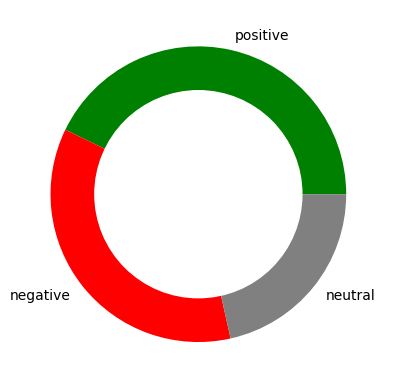

In [46]:
#create a circle for the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color = 'white')
plt.pie(size2, labels=names, colors=['green', 'red', 'grey'])
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

#### Review Negative Tweets

In [41]:
neg_tweets = df2[(df2['Sentiment']=='negative') & (df2['comp_score']<= -0.05)]

In [42]:
neg_tweets.head(20)

,tweet,Mitch_Kevin_Knew,comp_score,Sentiment
1,thing pathetic acting sec defense chris miller person deploy national,0.00286,-0.4939,negative
2,thing pathetic acting sec defense chris miller person deploy national,0.00286,-0.4939,negative
5,shit heavy take care,0.00239,-0.1027,negative
13,condone violence behind speaker nancyisabadass punchhimout lockhimupalready,0.05343,-0.6249,negative
15,secret service clearly involved coverup trump riot capitol trumpscoupplaybook janua,0.67515,-0.2263,negative
18,keep supporting racist gop attempted military coup cult45,0.03263,-0.2732,negative
21,thing pathetic acting sec defense chris miller person deploy national,0.00286,-0.4939,negative
24,trump claim pelosi failed call law enforcement 6 undermined literal video evidence,0.70041,-0.7003,negative
25,experienced writers brutal every assignment essay amp online class dm 1 256 703 7208 gsu uwg jsu csu,0.00664,-0.6249,negative
29,experienced writers brutal every assignment essay amp online class dm 1 256 703 7208 gsu uwg jsu csu,0.00664,-0.6249,negative


#### Review Positive Tweets

In [43]:
pos_tweets = df2[(df2['Sentiment']=='positive') & (df2['comp_score']>= 0.05)]
pos_tweets.head(20)

,tweet,Mitch_Kevin_Knew,comp_score,Sentiment
4,mitch mcconnell kevin mccarthy knew trump responsible called backed,2.71542,0.3400,positive
6,another graphic designed talented team go ahead use share tweet truth pl,0.00364,0.7783,positive
7,new video trump lost yet decided hatch coup help mark meadows roger stone rudy giuliani,0.98417,0.1027,positive
9,maga gop mark hamill correct love country without creating violence overthrowing democracy,0.15107,0.7654,positive
12,maga gop mark hamill correct love country without creating violence overthrowing democracy,0.15107,0.7654,positive
17,maga gop mark hamill correct love country without creating violence overthrowing democracy,0.15107,0.7654,positive
22,vp mike pence security detail getting car secret service reported hearing pence dea,0.04156,0.3400,positive
23,mitch mcconnell kevin mccarthy knew trump responsible called backed,2.71542,0.3400,positive
26,think someone craves attention like would jump chance tell side story course,0.01570,0.5423,positive
27,maga gop mark hamill correct love country without creating violence overthrowing democracy,0.15107,0.7654,positive
